In [2]:
import sys # for automation and parallelization
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

# OSMNX

In [3]:
import sys
sys.path.insert(0, r'../../../quetzal')

import geopandas as gpd
from shapely import geometry
import osmnx as ox
import geopandas as gpd
import os

from syspy.spatial.graph.graphbuilder import GraphBuilder, OsmnxCleaner
from syspy.spatial.graph import graphbuilder

training_folder = '../../'
input_folder = training_folder + r'inputs/'

In [4]:
if manual:
    %matplotlib inline
    
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 9]

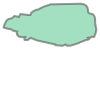

In [5]:
zones = gpd.read_file(r'../../inputs/zones/zones.geojson')
hull = geometry.MultiPolygon(zones['geometry'].values).buffer(1e-3)
hull

# OSMNX API

In [6]:
drive = ox.graph_from_polygon(hull, network_type='drive')

In [7]:
# plot = ox.plot_graph(drive)

In [8]:
road_nodes, road_links = ox.graph_to_gdfs(drive)

In [9]:
road_links.reset_index(inplace=True)
road_nodes.reset_index(inplace=True)

In [10]:
road_nodes['osmid'] = road_nodes['osmid'].astype(str)
road_nodes = road_nodes.set_index('osmid')[['geometry']]

road_links.rename(columns={'u': 'from', 'v': 'to'}, inplace=True)
road_links[['from', 'to']] = road_links[['from', 'to']].astype(str)

# cleaning

In [11]:
from shapely import geometry
def simplify_link(g):
    l = list(g.coords)
    return geometry.LineString([l[0], l[-1]])

In [12]:
road_links['geometry'] = road_links['geometry'].apply(simplify_link)
oc = OsmnxCleaner(
    road_links, 
    road_nodes, 
    a='from', 
    b='to'
)

In [13]:
oc.add_reversed_links(
    direction_column='oneway', 
    reverse_value=False # the boolean has been stored as a string    
)
oc.clean_geometries()
oc.fix_nodeset_consistency()

c:\Users\rgoix\Documents\dev\quetzal_models\lome\quetzal_paris\notebooks\transport\../../../quetzal\syspy\spatial\graph\graphbuilder.py:259: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  self.nodes = self.nodes.loc[set(self.links['a']).union(self.links['b'])]


# Export 

In [23]:
from quetzal.model.stepmodel import StepModel

sm = StepModel(epsg=4326, coordinates_unit='degree')
sm.road_links = oc.links[['a', 'b', 'length', 'geometry', 'highway']].copy()
sm.road_nodes = oc.nodes[['geometry']].copy()

In [24]:
sm.integrity_fix_road_network(cutoff=10, recursive_depth=5)

direct: 9981it [00:01, 7365.81it/s]
reversed: 9981it [00:01, 6813.73it/s]
9714it [00:01, 7527.71it/s]


In [25]:
sm.road_links['highway'] = sm.road_links['highway'].astype(str)
irrelevant = ['pedestrian', 'footway', 'service', 'cycleway', 'residential']
sm.road_links = sm.road_links.loc[~sm.road_links['highway'].isin(irrelevant)]

In [26]:
sm.to_json(input_folder + 'road', only_attributes=['road_links', 'road_nodes'])

to_hdf(overwriting): 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]
